In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import pickle

from gensim.models import KeyedVectors

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
import keras.backend as K

from evaluation_metrics import r_precision

2022-02-23 09:34:45.228727: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-23 09:34:45.228751: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# Path to project data
data_path = '/recsys/data/spotify/s2v_data/'
# Path to trian and test file
pickle_file = 'sentences_and_maps.pickle'
# Path to Word2Vec embeddings
vectors_file = 'song_vectors.kv'
# Path to encoder dataset which we create here if it doesnt exist
encoder_dataset = 'encoder_dataset_1M.pickle'

In [3]:
with open(data_path + pickle_file, 'rb') as handle:
    train, test, track_data_map, reverse_track_lookup = pickle.load(handle)

In [4]:
train = [val.split() for val in train]
test = [val.split() for val in test]

wv = KeyedVectors.load(data_path + vectors_file)

In [5]:
# wv.init_sims(replace=True)

## Dataset creation
- Dataset is created as (song1_embedding, song2_embedding) for songs found one after another if both sonds have embeddings
- We created 2 datasets, 1 of 500K examples and the other of 1M examples

In [6]:
# creating train and validation sets
# taking 500 for train, 50 for validation
try:
    with open(data_path + encoder_dataset, 'rb') as handle:
        train_in, train_out, val_in, val_out = pickle.load(handle)

except Exception as e:   
    print('Loading failed: {}'.format(e))
    print('Creating dataset')
    train_in, train_out, val_in, val_out = [], [], [], []

    train_size = 0
    validation_size = 0
    add_to_train = True

    for pl in train:
        prev_song = None

        if len(train_in) >= 1000000:
            add_to_train = False
        if len(val_in) >= 100000:
            break

        for s in pl:
            if s in wv.index_to_key:
                if prev_song:
                    if add_to_train:
                        train_in.append(wv.get_vector(prev_song))
                        train_out.append(wv.get_vector(s))
                    else:
                        val_in.append(wv.get_vector(prev_song))
                        val_out.append(wv.get_vector(s))

                prev_song = s
            else:
                prev_song = None

    data = train_in, train_out, val_in, val_out
    with open(data_path + encoder_dataset, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
train_in, train_out= np.array(train_in), np.array(train_out)
val_in, val_out = np.array(val_in), np.array(val_out)

In [8]:
train_in = train_in.reshape(train_in.shape[0], 64, 1)
train_out = train_out.reshape(train_in.shape[0], 64, 1)
val_in = val_in.reshape(val_in.shape[0], 64, 1)
val_out = val_out.reshape(val_in.shape[0], 64, 1)

## Model
- The model is an Encoder Decoder model
- The input is a song embedding
- The output is also a song embedding

- The target is given a song, predict the embedding of the next song

In [9]:
class ProdEmbToEmb(Model):
  def __init__(self):
    super(ProdEmbToEmb, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(64, 1)),
      layers.Flatten(),
      layers.Dense(32, activation='selu'),
      layers.Dropout(0.2),
      layers.Dense(32, activation='selu')])

    self.decoder = tf.keras.Sequential([
      layers.Dense(32, activation='selu'),
      layers.Dropout(0.3),
      layers.Dense(64, activation='selu'),
      layers.Dropout(0.3),
      layers.Dense(64, activation='linear'),
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = ProdEmbToEmb()

2022-02-23 09:35:01.318914: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-02-23 09:35:01.318947: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (kal-syl): /proc/driver/nvidia/version does not exist
2022-02-23 09:35:01.319199: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
autoencoder.compile(optimizer='adamax', loss=losses.MeanSquaredError())

In [11]:
history = autoencoder.fit(train_in, train_out,
                          epochs=30,
                          shuffle=True,
                          validation_data=(val_in, val_out))

Epoch 1/30
31251/31251 [==============================] - 35s 1ms/step - loss: 1.5476 - val_loss: 1.4374
Epoch 2/30
31251/31251 [==============================] - 38s 1ms/step - loss: 1.5040 - val_loss: 1.4297
Epoch 3/30
31251/31251 [==============================] - 39s 1ms/step - loss: 1.4972 - val_loss: 1.4231
Epoch 4/30
31251/31251 [==============================] - 34s 1ms/step - loss: 1.4928 - val_loss: 1.4200
Epoch 5/30
31251/31251 [==============================] - 33s 1ms/step - loss: 1.4903 - val_loss: 1.4159
Epoch 6/30
31251/31251 [==============================] - 33s 1ms/step - loss: 1.4883 - val_loss: 1.4159
Epoch 7/30
31251/31251 [==============================] - 33s 1ms/step - loss: 1.4871 - val_loss: 1.4149
Epoch 8/30
31251/31251 [==============================] - 34s 1ms/step - loss: 1.4861 - val_loss: 1.4122
Epoch 9/30
31251/31251 [==============================] - 33s 1ms/step - loss: 1.4852 - val_loss: 1.4108
Epoch 10/30
31251/31251 [==============================

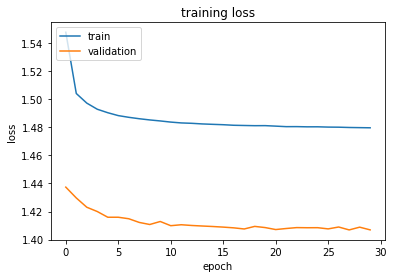

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
autoencoder.encoder.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
Total params: 3,136
Trainable params: 3,136
Non-trainable params: 0
_________________________________________________________________


In [14]:
autoencoder.decoder.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
Total params: 7,328
Trainable params: 7,328
Non-trainable params: 0
_________________________________________________________________


## Prediction
prediction is done as follows:
- Given a song we encode it end decode it using the model
- Then we search for the nearest embeddings to the decoded vector
- We recommend the song with the nearest embeddings

In [15]:
def predict_using_similarity_to_decoding(s_sample, k, wv):
    songs_in_dict = []
    all_results = []
    for s in s_sample:
        if s in wv.key_to_index:
            songs_in_dict.append(s)
    
    if songs_in_dict:
        for s in songs_in_dict:
            vec = wv.get_vector(s).reshape(1, 64, 1)
            encoded_vec = autoencoder.encoder(vec).numpy()
            decoded_vec = autoencoder.decoder(encoded_vec).numpy()
            temp_results = wv.similar_by_vector(decoded_vec[0], topn=int(k / len(songs_in_dict)))
            all_results.extend(temp_results)
        
        return all_results[:100]
    else:
        return None

In [16]:
%%time
similarity_prediction = [predict_using_similarity_to_decoding(sample[:3], 100, wv) for sample in test[:10000]]
test = [val for val, tester in zip(test, similarity_prediction) if tester]
similarity_prediction = [val for val in similarity_prediction if val]

CPU times: user 2min 21s, sys: 1min 58s, total: 4min 19s
Wall time: 33.6 s


In [17]:
r_precision(test, similarity_prediction)

0.1263698293774981

In [18]:
autoencoder.save(data_path + 'emb_to_emb_encoder.model')

2022-02-23 10:16:09.510242: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /home/kal/recsys/data/spotify/s2v_data/emb_to_emb_encoder.model/assets
